In [ ]:
#IMPORT PACKAGES AND LIBRARIES

In [1]:
#!pip install pymongo
#!pip install psycopg2
#!pip install wordcloud
import pymongo
import requests
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import exc
from sqlalchemy import inspect

In [ ]:
#DATA CLEANING AND PREPROCESSING

In [4]:
import pandas as pd

# Load the dataset
diseaseOutbreak = pd.read_csv("/Users/Preetham/Desktop/Data Analytics/DAP Projects/outbreaks.csv")

# Define a function to drop unrelated columns and create new ones
def drop_and_create_columns(diseaseOutbreak):
    # Drop the "Serotype/Genotype" column
    columns_to_drop = ["Serotype/Genotype"]
    diseaseOutbreak.drop(columns_to_drop, axis=1, inplace=True)
    
    # Create a new "Location_State" column by combining the "Location" and "State" columns
    diseaseOutbreak["Location_State"] = diseaseOutbreak["Location"] + ", " + diseaseOutbreak["State"]
    
    return diseaseOutbreak

# Define a function to remove missing values
def remove_missing_values(diseaseOutbreak):
    diseaseOutbreak.dropna(inplace=True)
    return diseaseOutbreak

# Drop unrelated columns and create new ones
diseaseOutbreak = drop_and_create_columns(diseaseOutbreak)

# Remove missing values
diseaseOutbreak = remove_missing_values(diseaseOutbreak)

diseaseOutbreak.to_csv('outbreak_Clean.csv',index=False)

In [ ]:
#RUN DATABASE CONNECTION FILE

In [5]:
%run ./db_connections.ipynb

In [ ]:
#TABLE CREATION AND DATA LOADING INTO POSTGRESQL

In [6]:
# Function to create a table in PostgreSQL database for FDA data.

def create_disease_outbreak_table(conn, table_name):
    try:
        cur = conn.cursor() # Create a cursor object for executing SQL queries.
        # SQL query to create the table with column names and data types.
        cur.execute(f'''
            CREATE TABLE IF NOT EXISTS {table_name} (
                 Year VARCHAR(255),
                 Month VARCHAR(255),
                 State VARCHAR(255),
                 Location VARCHAR(255),
                 Food VARCHAR(255),
                 Ingredient VARCHAR(255),
                 Species VARCHAR(255),
                 Status VARCHAR(255),
                 illnesses VARCHAR(255),
                 Hospitalizations VARCHAR(255),
                 Fatalities VARCHAR(255),
                 Location_State VARCHAR(255)
            )
        ''')
        conn.commit() # Commit the transaction.
        print("Table created successfully!")
    except psycopg2.Error as e:
        print("Error creating table:", e)
        conn.rollback() # Rollback the transaction in case of an error.
    finally:
        cur.close() # Close the cursor.
        
table_name = postgresOutbreaktablename
create_disease_outbreak_table(conn, table_name)

Table created successfully!


In [8]:
# Function to load data from a DataFrame to a PostgreSQL table.

def load_disease_outbreak_to_postgresql(conn, diseaseOutbreak, table_name):
    try:
        engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
        inspector = inspect(engine)
        # Check if the table already contains data, if so, delete all the rows.
        if table_name in inspector.get_table_names():
            with conn.cursor() as cursor:
                cursor.execute(f"DELETE FROM {table_name}")
                conn.commit()  # Commit the DELETE statement
                #print(f"All rows deleted from table '{table_name}'.")
        diseaseOutbreak.to_sql(table_name, engine, if_exists='append', index=False)
        engine.dispose() # Dispose the engine after data is loaded.
        print("Data loaded to PostgreSQL successfully!")
    except exc.SQLAlchemyError as e:
        print("Error loading data to PostgreSQL:", e)

load_disease_outbreak_to_postgresql(conn, diseaseOutbreak, table_name)

Data loaded to PostgreSQL successfully!


In [ ]:
#EXTRACT THE PRE-PROCESSED AND STRUCTURED DATA WHICH IS LOADED INTO POSTGRES INTO A PANDAS DATAFRAME

In [9]:
# Function to extract data from PostgreSQL table and load it into a DataFrame

def extract_disease_data_from_postgresql(engine, table_name):
    try:
        
        # Define the query to extract data
        query = f'SELECT * FROM {table_name}'
        df = pd.read_sql(query, engine)
        print("Data loaded from PostgreSQL to DataFrame successfully!")
        return df
    except Exception as e:
        print("Error loading data from PostgreSQL to DataFrame:", e)

engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
disease_df_cleaned = extract_disease_data_from_postgresql(engine, table_name)

Data loaded from PostgreSQL to DataFrame successfully!


In [10]:
disease_df_cleaned.tail()

,Year,Month,State,Location,Food,Ingredient,Species,Status,Illnesses,Hospitalizations,Fatalities,Location_State
1269,2015,December,Florida,Private Home/Residence,"Fish, Baracuda","Fish, Baracuda",Ciguatoxin,Confirmed,5,0.0,0.0,"Private Home/Residence, Florida"
1270,2015,December,Michigan,Private Home/Residence,Cake,Frosting/Icing,Norovirus genogroup II,Confirmed,73,0.0,0.0,"Private Home/Residence, Michigan"
1271,2015,December,Multistate,Private Home/Residence,Powder Meal Replacement,Moringa Leaf Powder,Salmonella enterica,Confirmed,35,6.0,0.0,"Private Home/Residence, Multistate"
1272,2015,December,Ohio,Farm/Dairy,"Milk, Unpasteurized","Milk, Whole Milk Unpasteurized",Campylobacter jejuni,Confirmed,2,2.0,0.0,"Farm/Dairy, Ohio"
1273,2015,December,South Carolina,Restaurant,Zucchini,Zucchini,Bacillus cereus,Suspected,8,0.0,0.0,"Restaurant, South Carolina"


In [ ]:
#CLOSE THE CONNECTION

In [ ]:
conn.close() #Close the connection

In [ ]:
                                        #VISUALIZATION

In [ ]:
#VISUALIZING FOR FOOD COLUMN IN BAR CHART PLOT

In [ ]:
#Which top 10 food items has the highest hospitalization rate and fatality rate combined?

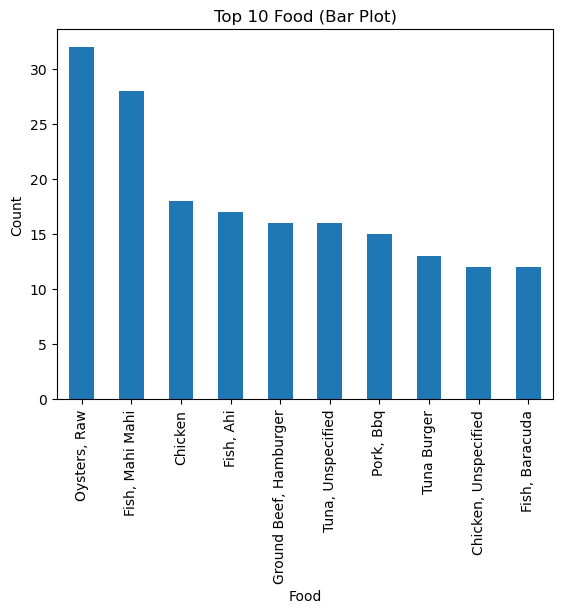

In [11]:
# import pandas as pd
import matplotlib.pyplot as plt

# Define the column to use
col = "Food"

# Get the top 10 values
top_10 = disease_df_cleaned[col].value_counts().nlargest(10)

# Create a bar plot
top_10.plot(kind="bar")
plt.xlabel(col)
plt.ylabel("Count")
plt.title(f"Top 10 {col} (Bar Plot)")
plt.show()

In [ ]:
#VISUALIZING FOR ILLNESS AND HOSPITALIZATIONS COLUMNS USING SCATTER PLOT GRAPHS

In [ ]:
#What is the relationship between the number of reported illnesses and hospitalizations in disease outbreaks, and how does this relationship vary across different types of outbreaks and demographic groups?

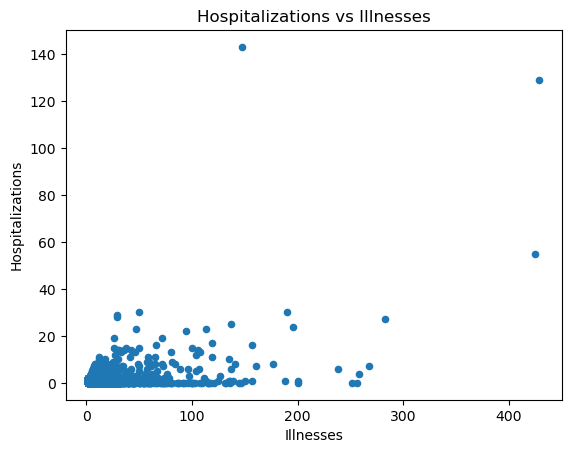

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Define a function to create a scatter plot
def create_scatter_plot(disease_df_cleaned, x_col, y_col):
    # Create a scatter plot using the x and y columns
    ax = disease_df_cleaned.plot(kind="scatter", x=x_col, y=y_col)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{y_col} vs {x_col}")
    
    plt.show()

# Create a scatter plot of illnesses vs hospitalizations
create_scatter_plot(disease_df_cleaned, "Illnesses", "Hospitalizations")


In [ ]:
#VISUALIZATION FOR YEAR AND ILLNESS USING LINE CHART

In [ ]:
#Are there any trends in the number of foodborne illnesses over time in the dataset?

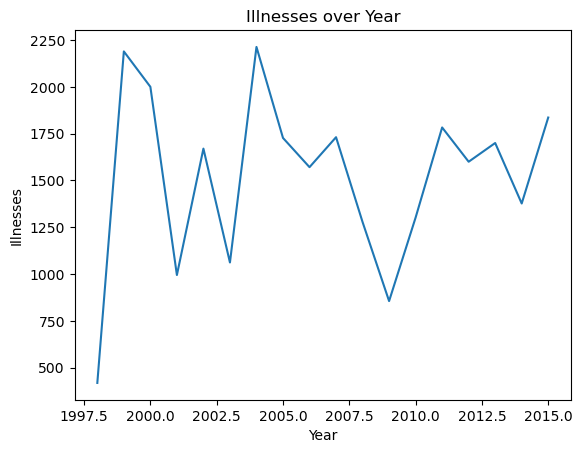

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Define a function to create a line chart
def create_line_chart(disease_df_cleaned, x_col, y_col):
    # Group the data by the x column and calculate the sum of the y column
    grouped = disease_df_cleaned.groupby(x_col)[y_col].sum()
    
    # Create a line chart using the grouped data
    ax = grouped.plot(kind="line")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{y_col} over {x_col}")
    
    plt.show()

# Create a line chart of illnesses over time
create_line_chart(disease_df_cleaned, "Year", "Illnesses")

In [ ]:
#VISUALIZATIONS FOR ILLNESS USING HISTOGRAM

In [ ]:
#What are the most effective strategies for preventing or mitigating the spread of illnesses based on the patterns and trends identified in the dataset?

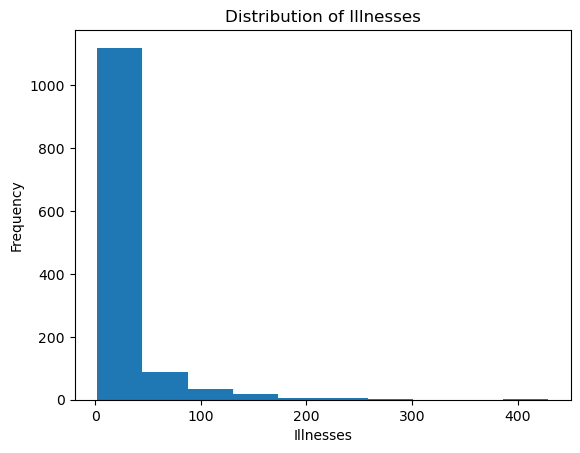

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


# Define a function to create a histogram
def create_histogram(disease_df_cleaned, col):
    # Create a histogram using the specified column
    ax = disease_df_cleaned[col].plot(kind="hist")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {col}")
    
    plt.show()

# Create a histogram of illness cases
create_histogram(disease_df_cleaned, "Illnesses")


In [ ]:
#What are the top 10 species that are most commonly associated with reported cases of illnesses and hospitalizations?

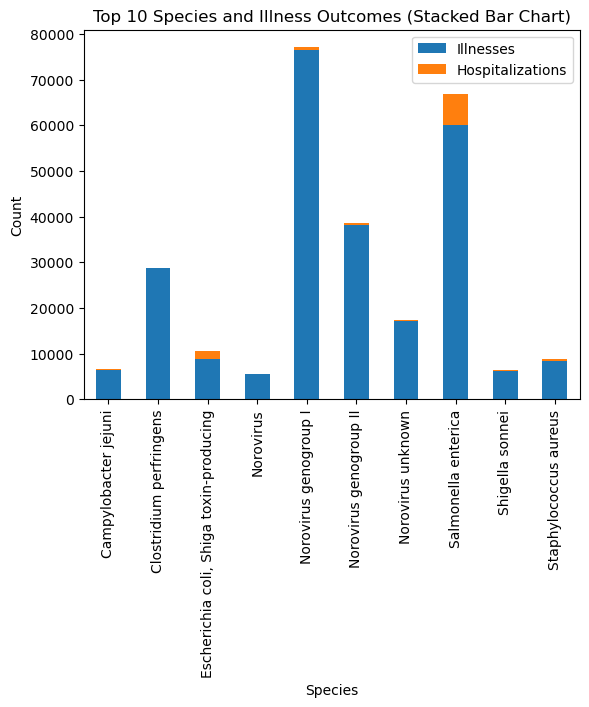

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Define the columns to use
x_col = "Species"
y_cols = ["Illnesses", "Hospitalizations"]

# Get the top 10 species based on total count of illnesses and hospitalizations
top_species = df.groupby(x_col)[y_cols].sum().sum(axis=1).nlargest(10).index.tolist()

# Filter the dataframe to only include the top 10 species
df_top_species = df[df[x_col].isin(top_species)]

# Create a stacked bar chart for the top 10 species
df_top_species.groupby(x_col)[y_cols].sum().plot(kind="bar", stacked=True)
plt.xlabel(x_col)
plt.ylabel("Count")
plt.title("Top 10 Species and Illness Outcomes (Stacked Bar Chart)")
plt.show()


In [ ]:
#what is the total number of reported illnesses for each of the top 10 species.

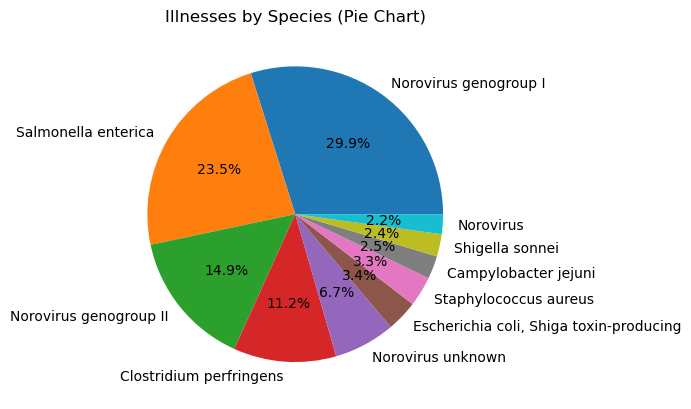

In [20]:
import pandas as pd
import matplotlib.pyplot as plt


# Define the columns to use
x_col = "Species"
y_col = "Illnesses"

# Group the data by species and sum the illnesses
species_counts = df.groupby(x_col)[y_col].sum()

# Sort the species counts in descending order
species_counts = species_counts.sort_values(ascending=False)

# Keep only the top 10 species
species_counts = species_counts[:10]

# Create a pie chart
plt.pie(species_counts.values, labels=species_counts.index, autopct='%1.1f%%')
plt.title(f"{y_col} by {x_col} (Pie Chart)")
plt.show()
